In [1]:
import os
import os.path

import numpy as np
import torch as T
import copy
import time
import matplotlib.pyplot as plt

import PyccatPO
from PyccatPOGPU import First_computing,model_ccat,read_input

import Kirchhoffpy
from Kirchhoffpy.Spheical_field import spheical_grid
from Kirchhoffpy.coordinate_operations import Coord

from Kirchhoffpy.coordinate_operations import Transform_local2global as local2global
from Kirchhoffpy.coordinate_operations import Transform_global2local as global2local
from Kirchhoffpy.coordinate_operations import cartesian_to_spherical as cart2spher
from Kirchhoffpy.Feedpy import CO,dotproduct
c=299792458


def field_calculation(source_field,frequency=100,
                      defocus=[0,0,705],
                      M2_N=[15,15],M1_N=[15,15],
                      fimag_N =[301,301],fimag_size =[700,700]):
    inputfile='CCAT_model'
    ad_m2=np.zeros(5*69)
    ad_m1=np.zeros((5,77))
    Lambda = c/(frequency*10**9)*1000
    k=2*np.pi/Lambda
    #sourcefile='beam'
    # 0. read the input parameters from the input files;
    coefficient_m2,coefficient_m1,List_m2,List_m1,M2_size,M1_size,R2,R1,p_m2,q_m2,p_m1,q_m1,M2_x,M1_x,fimag_X,fimag_sizeX,distance,edge_taper,Angle_taper,k_x=read_input(inputfile);
    
    # 1. produce the coordinate system;
    # 2. build model;
    print(M2_N,M1_N)
    print(fimag_N)
    m2,m2_n,m2_dA,m1,m1_n,m1_dA,fimag,fimag_n,fimag_dA=model_ccat(coefficient_m2,List_m2,M2_size[0],M2_size[1],M2_N[0],M2_N[1],R2,
                                                                  coefficient_m1,List_m1,M1_size[0],M1_size[1],M1_N[0],M1_N[1],R1,
                                                                  fimag_size[0],fimag_size[1],fimag_N[0],fimag_N[1],
                                                                  ad_m2,ad_m1,p_m2,q_m2,p_m1,q_m1);
    
    # 3.calculate the source beam
    Field_fimag_E,Field_fimag_H,Field_m1_E,Field_m1_H,Field_s_E,Field_s_H=First_computing(m2,m2_n,m2_dA,
                                                                                          m1,m1_n,m1_dA,
                                                                                          fimag,fimag_n,
                                                                                          fimag_dA,defocus,
                                                                                          source_field,k,
                                                                                          Angle_taper,edge_taper,Keepmatrix=False);
    
    return Field_fimag_E,Field_fimag_H,Field_m1_E,Field_m1_H,Field_s_E,Field_s_H


# near field calculation
def near_field(outputfolder,freq,Ns=201,
               defocus = [0,0,705],
               M2_N=[15,15],M1_N=[15,15],
               fimag_N =[301,301],fimag_size =[700,700]):
    Folder = outputfolder +str(freq)+'GHz/'
    if os.path.isdir(Folder):
        print("Exists")
    else:
        print("Doesn't exists")
        os.mkdir(Folder)
    Folder = Folder +str(M2_N[0])+'_'+str(M1_N[0])+'/'
    if os.path.isdir(Folder):
        pass
    else:
        print("Doesn't exists")
        os.mkdir(Folder)
    angle_s=[0,np.pi,0]      
    D_s=[0,0,0]

    if freq ==296:
        u = 0.01
        v = 0.01
    elif freq == 100:
        u = 0.03
        v = 0.03 
    source_field=spheical_grid(-u/2,u/2,-v/2,v/2,Ns,Ns,distance=300*10**3)
    source0=np.concatenate((source_field.x,source_field.y,source_field.z)).reshape(3,-1).T
    source=Coord()
    #source0=np.genfromtxt(sourcefile+'/on-axis.txt',delimiter=',');
    source.x=source0[...,0];source.y=source0[...,1];source.z=source0[...,2]
    
    Field_fimag_E,Field_fimag_H,Field_m1_E,Field_m1_H,Field_s_E,Field_s_H = field_calculation(source,
                                                                                              frequency=freq,
                                                                                              defocus=defocus,
                                                                                              M2_N=M2_N,
                                                                                              M1_N=M1_N,
                                                                                              fimag_N =fimag_N,
                                                                                              fimag_size =fimag_size)
    
    # calculate the co cx crho vectorsl;
    r,theta,phi=cart2spher(source.x,source.y,source.z)
    co,cx,crho=CO(theta,phi)

    Field_s_E.N=[]
    Field_s_E1=global2local(angle_s,[0,0,0],Field_s_E)

    F_co=dotproduct(Field_s_E1,co)
    F_cx=dotproduct(Field_s_E1,cx)
    F_crho=dotproduct(Field_s_E1,crho)

    #Sx=(Field_s_E.x.real+1j*Field_s_E.x.imag).reshape(Ns,Ns);
    #Sy=(Field_s_E.y.real+1j*Field_s_E.y.imag).reshape(Ns,Ns);
    #Sz=(Field_s_E.z.real+1j*Field_s_E.z.imag).reshape(Ns,Ns);

    Sx=(F_co.real+1j*F_co.imag).reshape(Ns,Ns)
    Sy=(F_cx.real+1j*F_cx.imag).reshape(Ns,Ns)
    Sz=(F_crho.real+1j*F_crho.imag).reshape(Ns,Ns)

    fig=plt.figure(figsize=(8,7))
    plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sx)))
    plt.xlabel('near-feild beam in amplitude (dB)',fontsize=18,color='darkred')
    plt.colorbar()
    plt.savefig(Folder+'near_field_beam.png')

    fig=plt.figure(figsize=(8,7))
    plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sy)))
    plt.xlabel('near-feild beam in amplitude (dB)',fontsize=18,color='darkred')
    plt.colorbar()
    plt.savefig(Folder+'near_field_beam_y.png')

    fig=plt.figure(figsize=(8,7))
    plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sz)))
    plt.xlabel('near-feild beam in amplitude (dB)',fontsize=18,color='darkred')
    plt.colorbar()
    plt.savefig(Folder+'near_field_beam_z.png')

    Source=np.concatenate((Sx.real,Sx.imag,Sy.real,Sy.imag,Sz.real,Sz.imag)).reshape(6,-1).T
    np.savetxt(Folder+'source_field.txt',Source,delimiter=',')

    Field_IF=np.concatenate((Field_fimag_E.x.real,Field_fimag_E.x.imag,
                             Field_fimag_E.y.real,Field_fimag_E.y.imag,
                             Field_fimag_E.z.real,Field_fimag_E.z.imag)).reshape(6,-1).T
    np.savetxt(Folder+'IF_field.txt',Field_IF,delimiter=',')

    Field_M1=np.concatenate((Field_m1_E.x.real,Field_m1_E.x.imag,Field_m1_E.y.real,Field_m1_E.y.imag,Field_m1_E.z.real,Field_m1_E.z.imag)).reshape(6,-1).T
    np.savetxt(Folder+'M1_field.txt',Field_M1,delimiter=',')

    




In [2]:
folder = 'output/infocus/GPU/'
if os.path.isdir(folder):
    print("Exists")
else:
    print("Doesn't exists")
    os.mkdir(folder) 

Exists


In [ ]:

Frequency = 100

near_field(folder,Frequency,Ns=201,
            defocus = [0,0,705],
            M2_N=[101,101],M1_N=[101,101],
            fimag_N =[301,301],fimag_size =[1000*3,1000*3])

In [ ]:
Frequency = 100

near_field(folder,Frequency,Ns=201,
            defocus = [0,0,705],
            M2_N=[101,101],M1_N=[101,101],
            fimag_N =[301,301],fimag_size =[1000*3,1000*3])

Exists
[401, 401] [401, 401]
[301, 301]
cores: 5


100%|██████████████████████████████████████████| 18120/18120 [2:23:33<00:00,  2.10it/s]


2
cores: 644


100%|██████████████████████████████████████████| 19226/19226 [2:29:52<00:00,  2.14it/s]


3
cores: 4


100%|██████████████████████████████████████████| 10100/10100 [1:11:07<00:00,  2.37it/s]


4
time used: 21881.71244956099


/tmp/ipykernel_296087/2707919426.py:117: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sx)))
/tmp/ipykernel_296087/2707919426.py:123: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sy)))
/tmp/ipykernel_296087/2707919426.py:129: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensi

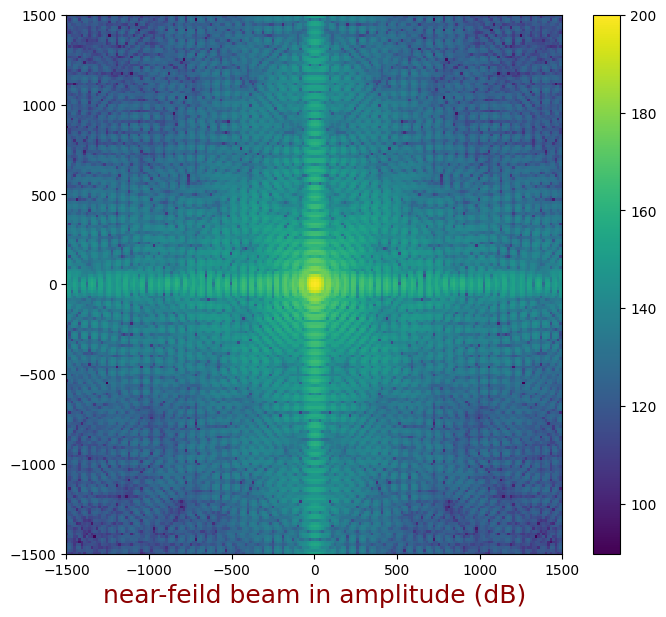

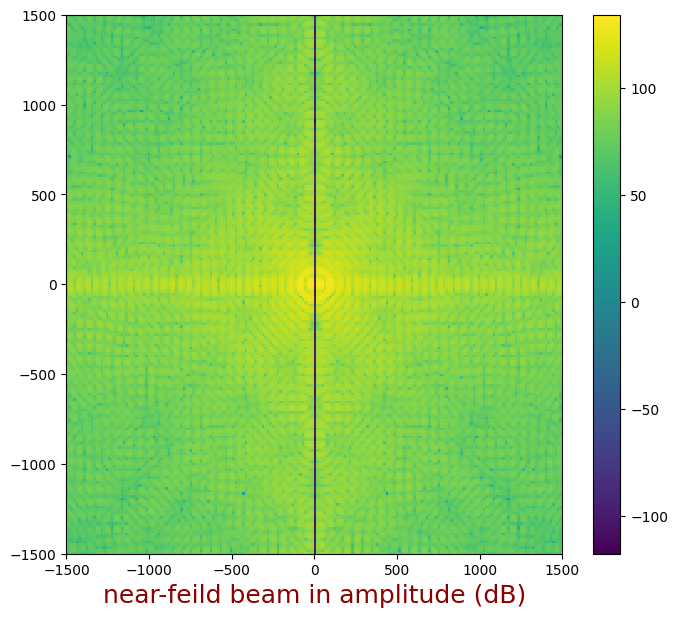

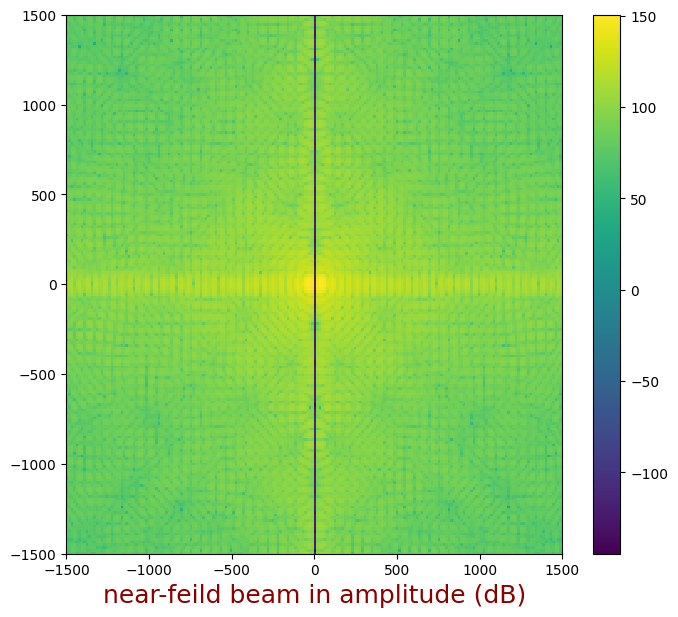

In [3]:
Frequency = 296

near_field(folder,Frequency,Ns=201,
            defocus = [0,0,705],
            M2_N=[401,401],M1_N=[401,401],
            fimag_N =[301,301],fimag_size =[1000,1000])

In [ ]:
Frequency = 296

near_field(folder,Frequency,Ns=201,
            defocus = [0,0,705],
            M2_N=[101,101],M1_N=[101,101],
            fimag_N =[301,301],fimag_size =[1000,1000])

Exists
Doesn't exists
[15, 15] [15, 15]
[301, 301]
cores: 1921
2
cores: 329
3
cores: 1721
4
time used: 361.3394425000006


C:\Users\xiaod\AppData\Local\Temp\ipykernel_24140\2707919426.py:117: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sx)))
C:\Users\xiaod\AppData\Local\Temp\ipykernel_24140\2707919426.py:123: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sy)))
C:\Users\xiaod\AppData\Local\Temp\ipykernel_24140\2707919426.py:

Exists
Doesn't exists
[17, 17] [17, 17]
[301, 301]
cores: 1495
2
cores: 329
3
cores: 1340
4
time used: 348.8802317999998
Exists
Doesn't exists
[21, 21] [21, 21]
[301, 301]
cores: 980
2
cores: 329
3
cores: 878
4
time used: 529.8886715999997
Exists
Doesn't exists
[25, 25] [25, 25]
[301, 301]
cores: 691
2
cores: 329
3
cores: 619
4
time used: 758.6478134999998
Exists
Doesn't exists
[51, 51] [51, 51]
[301, 301]
cores: 166
2
cores: 329
3
cores: 148
4
time used: 3147.050278499999


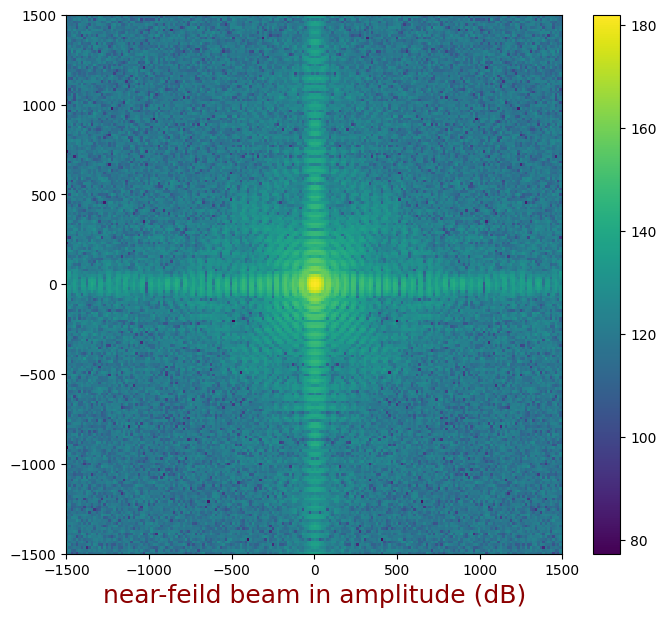

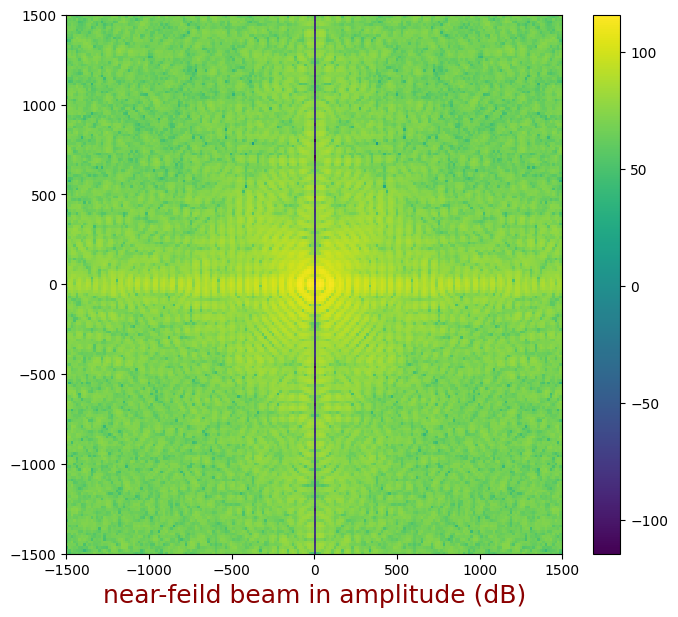

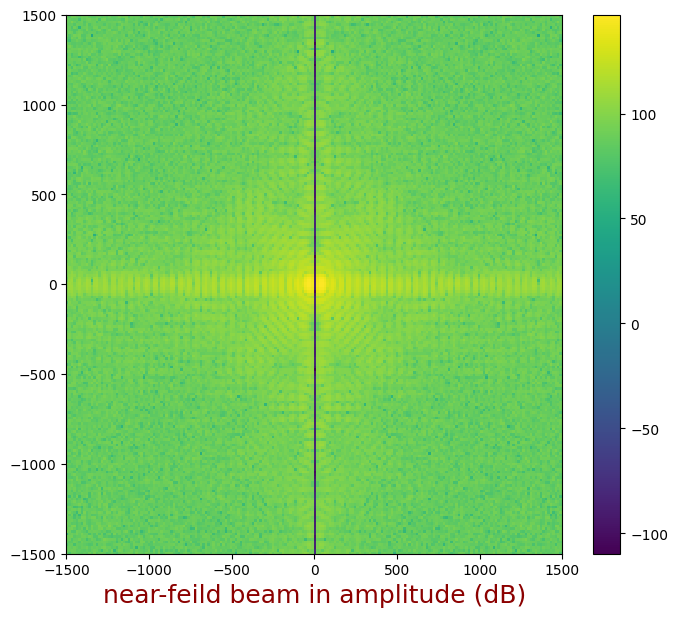

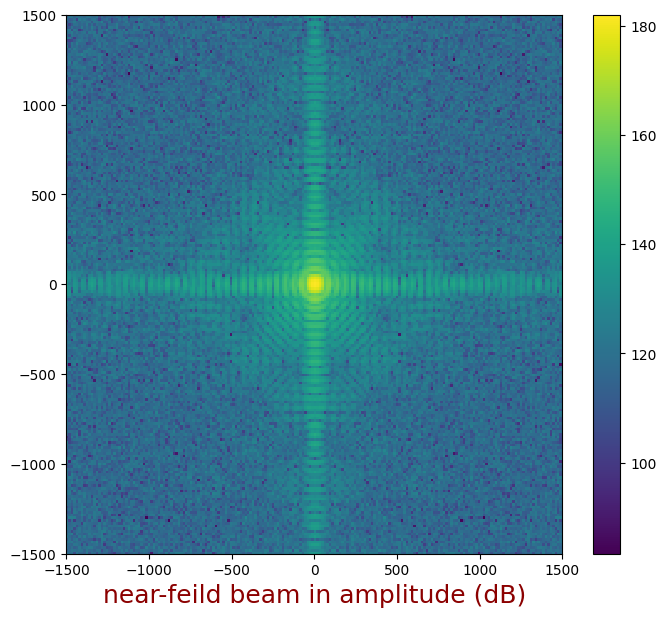

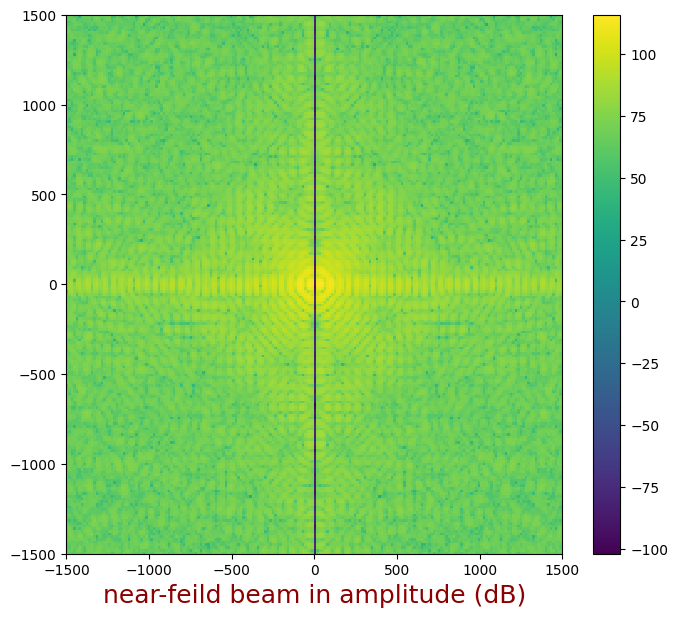

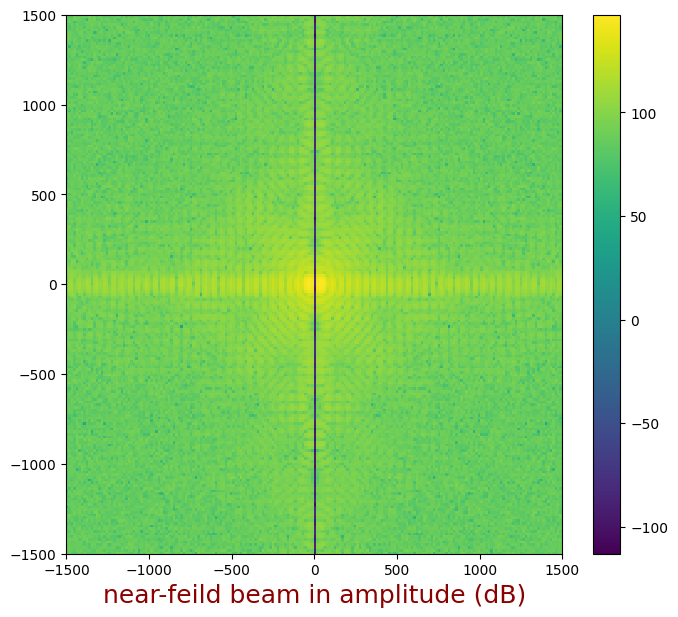

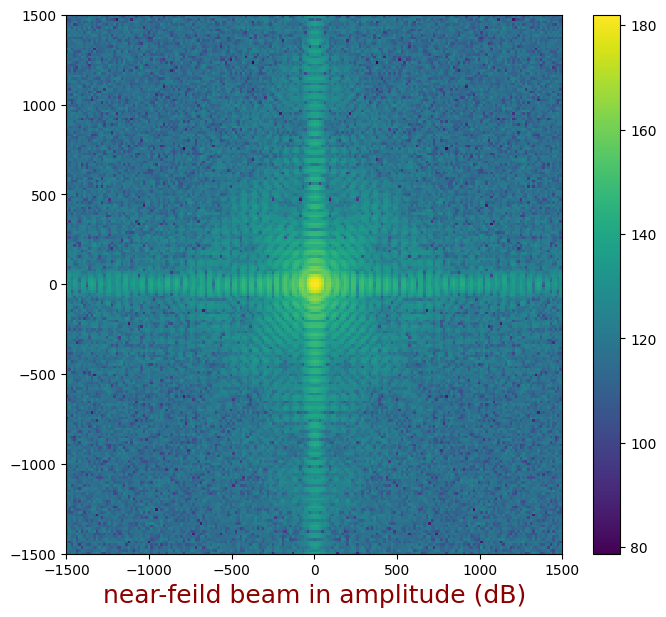

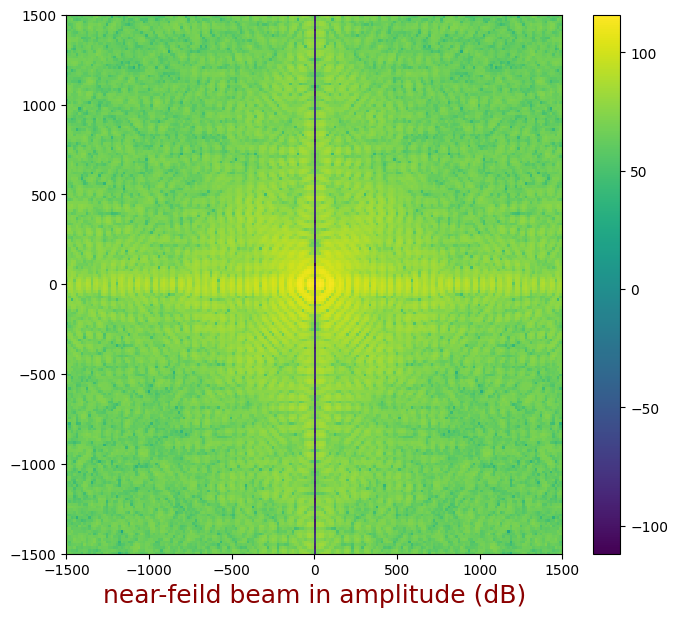

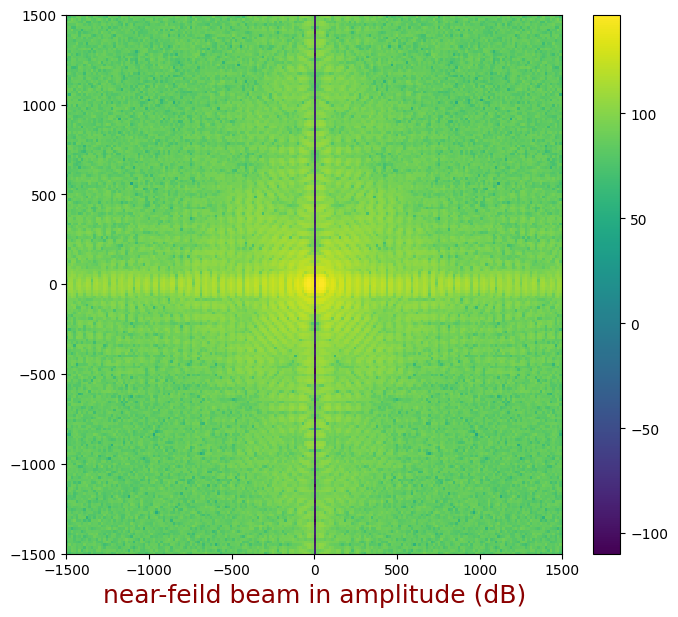

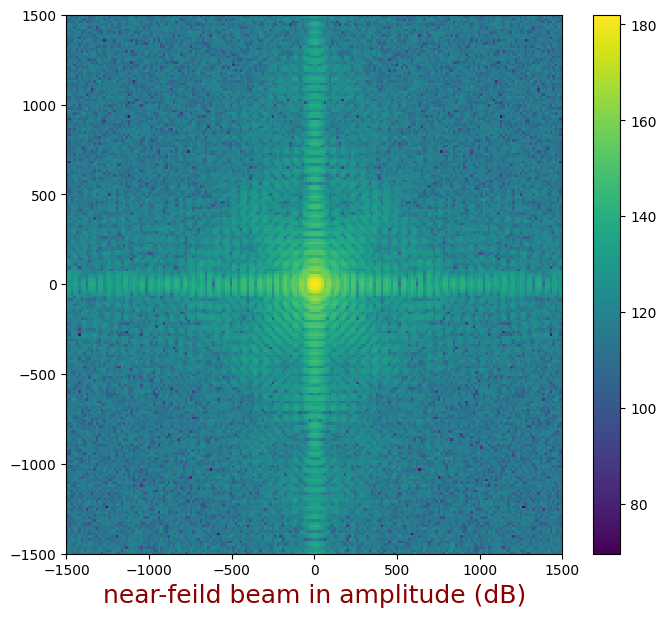

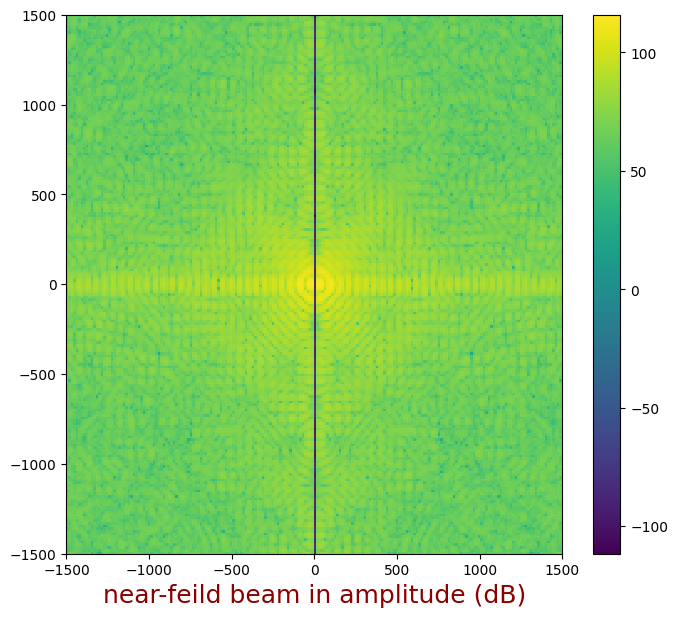

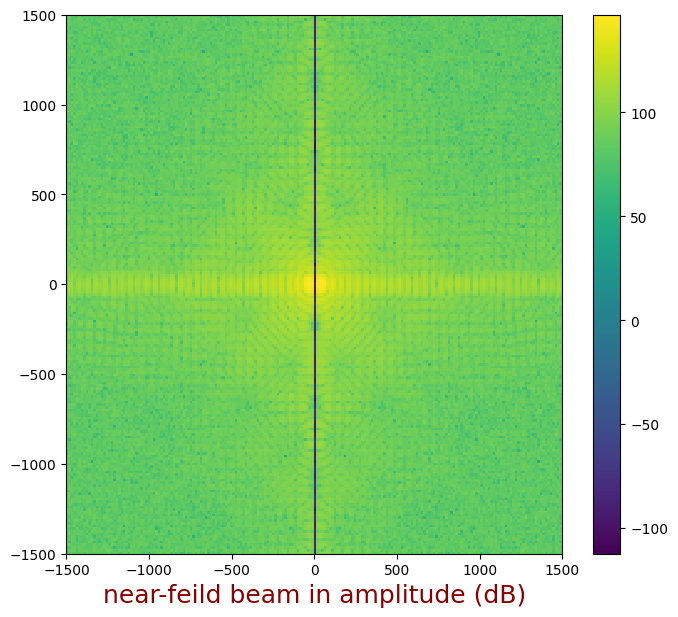

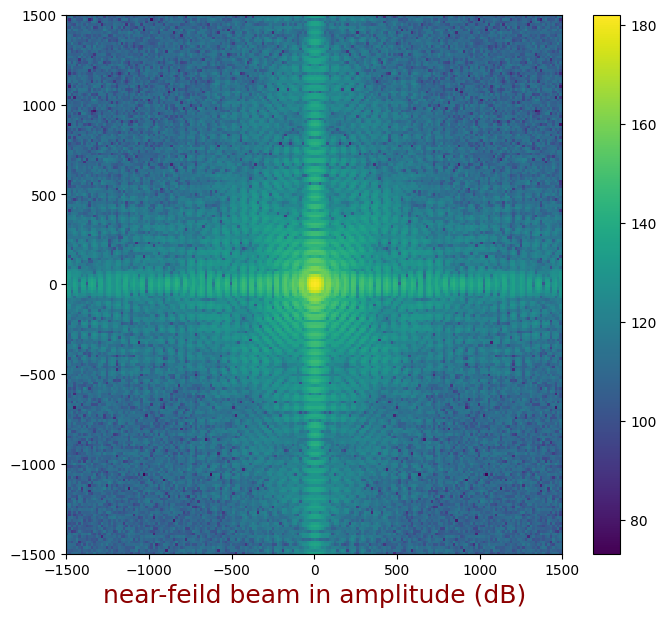

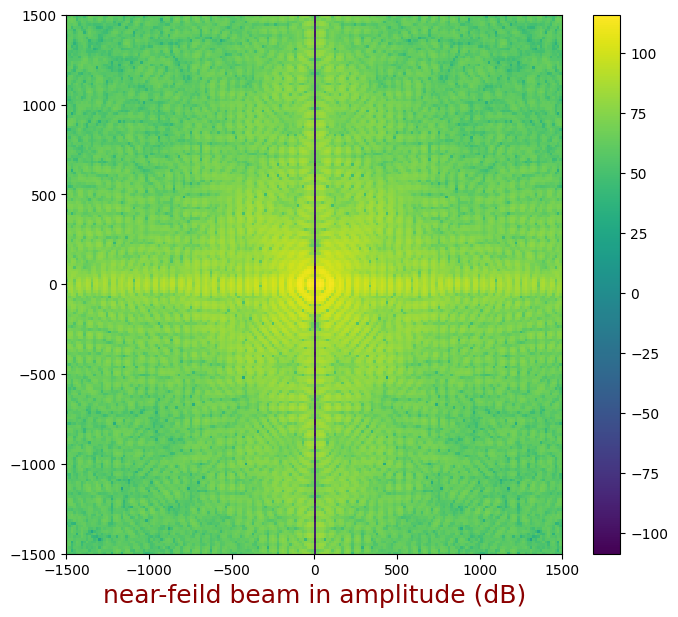

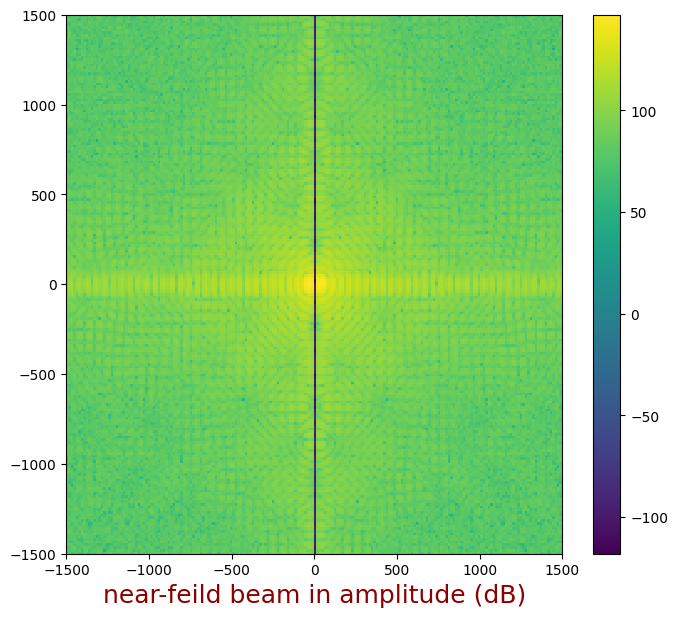

In [ ]:
Frequency = 296

for sampling_n in [11,15,17,21,25,51]:
    near_field(folder,Frequency,Ns=201,
            defocus = [0,0,705],
            M2_N=[sampling_n,sampling_n],M1_N=[sampling_n,sampling_n],
            fimag_N =[301,301],fimag_size =[1000,1000])

Exists
Doesn't exists
[201, 201] [201, 201]
[301, 301]
cores: 10


100%|██████████| 9060/9060 [56:26<00:00,  2.68it/s]  


2
cores: 329


100%|██████████| 9455/9455 [1:01:38<00:00,  2.56it/s]


3
cores: 9


100%|██████████| 4489/4489 [27:10<00:00,  2.75it/s]
C:\Users\xiaod\AppData\Local\Temp\ipykernel_26704\2707919426.py:117: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sx)))


4
time used: 8719.0179348


C:\Users\xiaod\AppData\Local\Temp\ipykernel_26704\2707919426.py:123: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sy)))
C:\Users\xiaod\AppData\Local\Temp\ipykernel_26704\2707919426.py:129: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sz)))


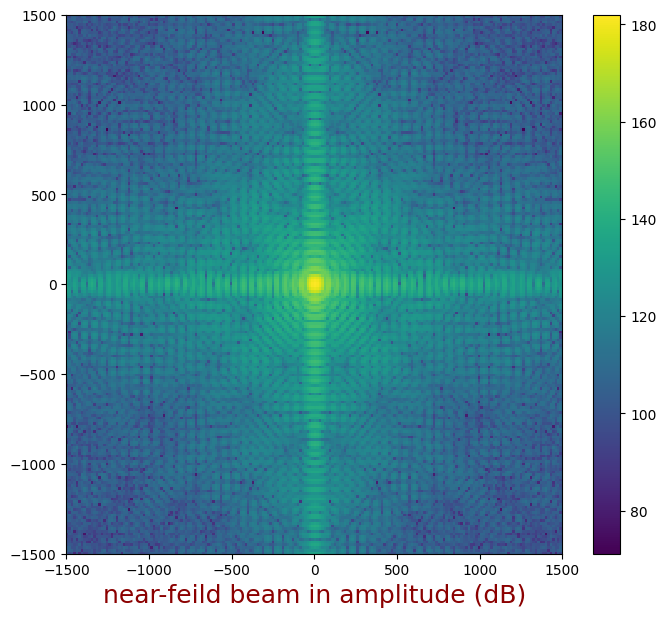

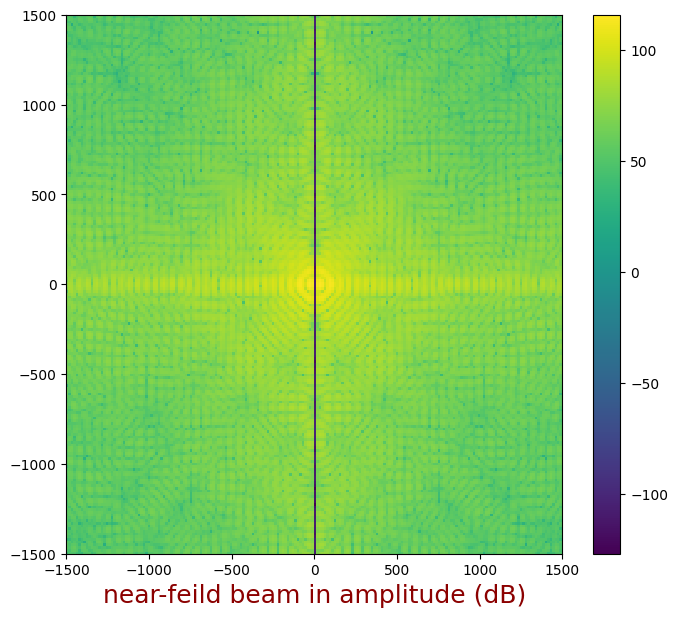

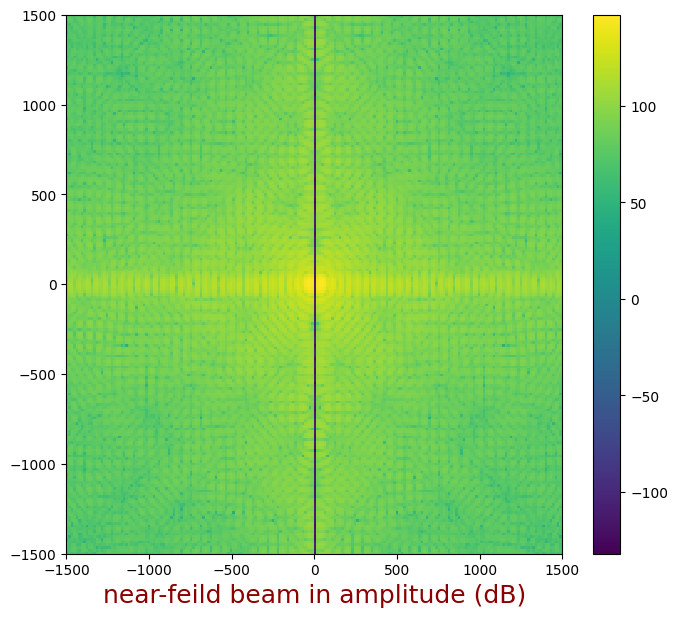

In [5]:
Frequency = 296

for sampling_n in [201]:
    near_field(folder,Frequency,Ns=201,
            defocus = [0,0,705],
            M2_N=[sampling_n,sampling_n],M1_N=[sampling_n,sampling_n],
            fimag_N =[301,301],fimag_size =[1000,1000])

In [ ]:
Frequency = 296

for sampling_n in [201]:
    near_field(folder,Frequency,Ns=201,
            defocus = [0,0,705],
            M2_N=[sampling_n,sampling_n],M1_N=[sampling_n,sampling_n],
            fimag_N =[301,301],fimag_size =[1000,1000])

Exists
Doesn't exists
[101, 101] [101, 101]
[301, 301]
cores: 42


100%|██████████| 2157/2157 [15:21<00:00,  2.34it/s]


2
cores: 329


100%|██████████| 2387/2387 [17:03<00:00,  2.33it/s]


3
cores: 37


100%|██████████| 1091/1091 [07:51<00:00,  2.31it/s]


4
time used: 2417.8782407


C:\Users\xiaod\AppData\Local\Temp\ipykernel_4780\2707919426.py:117: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sx)))
C:\Users\xiaod\AppData\Local\Temp\ipykernel_4780\2707919426.py:123: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(source.x.reshape(Ns,Ns),source.y.reshape(Ns,Ns),20*np.log10(np.abs(Sy)))
C:\Users\xiaod\AppData\Local\Temp\ipykernel_4780\2707919426.py:129

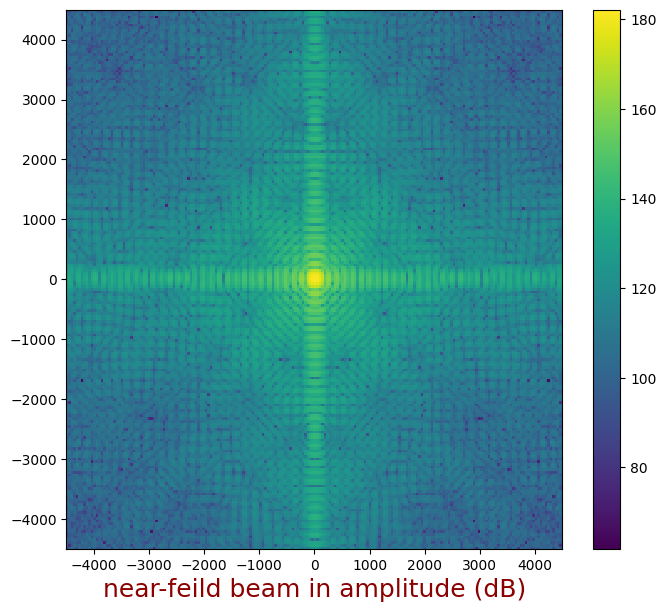

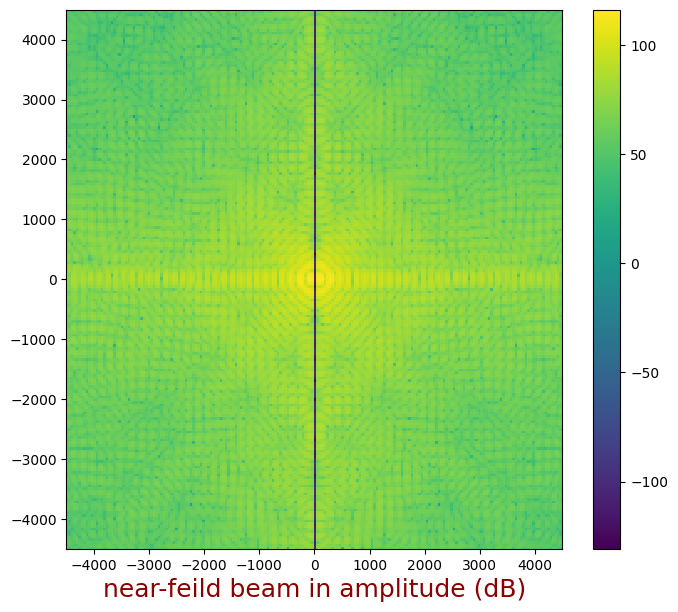

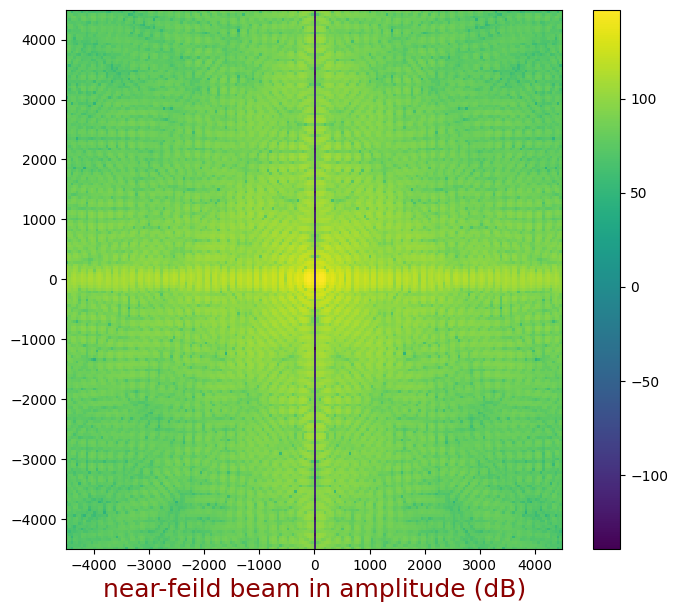

In [4]:
Frequency = 100

for sampling_n in [101]:
    near_field(folder,Frequency,Ns=201,
            defocus = [0,0,705],
            M2_N=[sampling_n,sampling_n],M1_N=[sampling_n,sampling_n],
            fimag_N =[301,301],fimag_size =[1000*3,1000*3])